# The Problem of Loanwords: Detection and Remedies

# Detect Transliterated Greek
### In this notebook you will:
1. ETL (Extract-Transform-Load) data
    1. Extract data using a Corpus Reader object
    1. Transform data using a reusable, composable Scikit-Learn Pipeline object
    1. Load the data into a data matrix and a classifier
1. Train several classifiers and select the best algorithm for the data
1. Use GridSearch to tune hyperparameters to achieve the best algorithm performance
1. Use the classifier to predict whether or not a word is transliterated Greek
1. Examine some unseen, untrained data to discover how well the classifier generalizes to unseen data
1. Save the classifier for reuse
1. Record the trained classifier model's provenance
## Why? 
### If you desire to make a high quality word embedding, you will probably want to filter out Greek words which may appear transliterated into Latin. Often Latin authors will quote transliterated Greek words (sometimes transliterated Greek words are valid Latin words, but most often they can pollute a computational view of the language). 
#### The data sets are: the works of Vergil, Eutropius, and Plato's Apologia transliterated into Latin. We will use our classifier to examine the corpus of Cicero to detect the use of transliterated Greek words, and we'll assess the classifier's effectiveness on the entire latin library corpus

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import datetime
import glob
import json
import logging
import multiprocessing
import os
import site
from copy import deepcopy
import random
from collections import defaultdict
import pickle

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from tqdm import tqdm
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.extmath import density
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from joblib import dump, load
import sklearn
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from cltk.stem.latin.j_v import JVReplacer
from cltk.prosody.latin.scansion_constants import ScansionConstants
from cltk.prosody.latin.string_utils import remove_punctuation_dict
from cltk.tokenize.word import WordTokenizer
from cltk.corpus.readers import get_corpus_reader
from cltk.utils.featurization import word_to_features
from cltk.utils.file_operations import md5
from cltk.utils.matrix_corpus_fun import (
    distinct_words,
    separate_camel_cases,
    drop_empty_lists,
    drop_non_lower,
    drop_arabic_numeric,
    drop_all_caps,
    drop_empty_strings,
    jv_transform,
    splice_hyphens,
    accept_editorial,
    profile_chars,
    demacronize,
    drop_enclitics,
    drop_fringe_punctuation,
    divide_separate_words,
    drop_all_punctuation)
plt.style.use('fivethirtyeight')

### Add parent directory to path so we can access our common code

In [3]:
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [4]:
from mlyoucanuse.romanizer import Romanizer, romanizer_transform  
from mlyoucanuse.aeoe_replacer import aeoe_transform
from mlyoucanuse.loanword_fun import run_length_encoding, extract_words, extract_consecutive_indices

### Turn on logging, primarily so that library methods may report warnings

In [5]:
LOG = logging.getLogger('make_model')
LOG.addHandler(logging.NullHandler())
logging.basicConfig(level=logging.INFO)

### Define a corpus reader and remap the _fileids to the text directory containing the corpus of Livy

In [6]:
latin_reader = get_corpus_reader('latin_text_latin_library', language='latin')
ALL_FILE_IDS = list(latin_reader.fileids())
good_files = [file for file in ALL_FILE_IDS
              if 'prudentius' in file or
              'caesar' in file or
              'eutropius' in file]
LOG.info('available good files %s', len(good_files))
latin_reader._fileids = good_files
good_files


INFO:make_model:available good files 41


['caesar/alex.txt',
 'caesar/bc1.txt',
 'caesar/bc2.txt',
 'caesar/bc3.txt',
 'caesar/bellafr.txt',
 'caesar/gall1.txt',
 'caesar/gall2.txt',
 'caesar/gall3.txt',
 'caesar/gall4.txt',
 'caesar/gall5.txt',
 'caesar/gall6.txt',
 'caesar/gall7.txt',
 'caesar/gall8.txt',
 'caesar/hisp.txt',
 'eutropius/eutropius1.txt',
 'eutropius/eutropius10.txt',
 'eutropius/eutropius2.txt',
 'eutropius/eutropius3.txt',
 'eutropius/eutropius4.txt',
 'eutropius/eutropius5.txt',
 'eutropius/eutropius6.txt',
 'eutropius/eutropius7.txt',
 'eutropius/eutropius8.txt',
 'eutropius/eutropius9.txt',
 'prudentius/prud.psycho.txt',
 'prudentius/prud1.txt',
 'prudentius/prud10.txt',
 'prudentius/prud11.txt',
 'prudentius/prud12.txt',
 'prudentius/prud13.txt',
 'prudentius/prud14.txt',
 'prudentius/prud2.txt',
 'prudentius/prud3.txt',
 'prudentius/prud4.txt',
 'prudentius/prud5.txt',
 'prudentius/prud6.txt',
 'prudentius/prud7.txt',
 'prudentius/prud8.txt',
 'prudentius/prud9.txt',
 'suetonius/suet.caesar.txt',
 'xyl

In [7]:
# remove some unfamiliar entries
questionable = ['caesar/alex.txt',
                'caesar/hisp.txt',
                'prudentius/prud.psycho.txt',
                'suetonius/suet.caesar.txt',
                'xylander/caesar.txt']
for file in questionable:
    good_files.remove(file)


### Define a custom Scikit-learn Pipeline, and call the CorpusReader `words()` method to process the texts
#### The functions used in the pipelines are doctest documented in the `corpus_cleaning` module
#### The functions used and their order was developed iteratively by running the pipelines on actual data and carefully inspecting the results.

In [8]:
process_latin_text_pipeline = Pipeline([
    ('separate_camel_cases', FunctionTransformer(separate_camel_cases, validate=False)),
    ('splice_hyphens', FunctionTransformer(splice_hyphens, validate=False)),
    ('jv_transform', FunctionTransformer(jv_transform, validate=False)),
    ('aeoe_transform', FunctionTransformer(aeoe_transform, validate=False)),
    ('accept_editorial', FunctionTransformer(accept_editorial, validate=False)),
    ('drop_enclitics', FunctionTransformer(drop_enclitics, validate=False)),
    ('drop_fringe_punctuation', FunctionTransformer(drop_fringe_punctuation, validate=False)),
    ('drop_all_punctuation', FunctionTransformer(drop_all_punctuation, validate=False)),
    ('drop_non_lower', FunctionTransformer(drop_non_lower, validate=False)),
    ('drop_arabic_numeric', FunctionTransformer(drop_arabic_numeric, validate=False)),
    ('drop_all_caps', FunctionTransformer(drop_all_caps, validate=False)),
    ('divide_separate_words', FunctionTransformer(divide_separate_words, validate=False)),
    ('drop_empty_lists', FunctionTransformer(drop_empty_lists, validate=False)),
    ('drop_empty_strings', FunctionTransformer(drop_empty_strings, validate=False))])

process_latin_text_pipeline_file = 'process_latin_text_pipeline.{}.joblib'.format(
    sklearn.__version__)
dump(process_latin_text_pipeline, process_latin_text_pipeline_file)


['process_latin_text_pipeline.0.20.2.joblib']

In [6]:
X = process_latin_text_pipeline.fit_transform(tqdm([list(latin_reader.words())]))

100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


### Analyze the resulting matrix, by profiling the character occurences and go back and adjust the pipeline as necessary, and turn the output into a distinct set of words

In [7]:
char_count = profile_chars(X)
print('Character distribution profile, total chars:', sum(char_count.values()))
print(char_count)
distinct_good_latin = distinct_words(X)
print(f'Number of distinct words in Eutropius/Prudentius/Caesar sample: {len(distinct_good_latin):,}')

Character distribution profile, total chars: 810414
Counter({'e': 93827, 'i': 90246, 'u': 75553, 't': 67540, 'a': 65821, 's': 62825, 'r': 54357, 'n': 49472, 'o': 44779, 'm': 41221, 'c': 31563, 'p': 23317, 'l': 23269, 'd': 20970, 'b': 13064, 'q': 12561, 'g': 8357, 'f': 7372, 'x': 4467, 'h': 4172, 'C': 2521, 'A': 1473, 'I': 1185, 'P': 1119, 'H': 1079, 'S': 1078, 'R': 965, 'G': 770, 'Q': 607, 'M': 601, 'T': 557, 'U': 546, 'N': 529, 'L': 475, 'E': 469, 'D': 459, 'y': 399, 'B': 351, 'F': 211, 'O': 203, 'z': 23, 'Z': 16, 'K': 11, 'k': 10, 'X': 3, 'Å': 1})
Number of distinct words in Eutropius/Vergil sample: 25,840


### Load the transliterated Greek examples, profile the raw character counts, and go back and tune the pipeline if necessary

In [9]:
perseus_greek = get_corpus_reader(language='greek', corpus_name='greek_text_perseus')
plato = [tmp for tmp in perseus_greek.fileids() if 'plato' in tmp]
homer = [tmp for tmp in perseus_greek.fileids() if 'homer' in tmp]
greek_texts = plato + homer

process_greek_pipeline = Pipeline([
    ('accept_editorial', FunctionTransformer(accept_editorial, validate=False)),  # problematic
    ('romanizer', FunctionTransformer(romanizer_transform, validate=False)),
    ('drop_fringe_punctuation', FunctionTransformer(drop_fringe_punctuation, validate=False)),
    ('drop_all_punctuation', FunctionTransformer(drop_all_punctuation, validate=False)),
    ('drop_arabic_numeric', FunctionTransformer(drop_arabic_numeric, validate=False)),  #ok
    ('drop_empty_lists', FunctionTransformer(drop_empty_lists, validate=False)),  # problem?
    ('drop_empty_strings', FunctionTransformer(drop_empty_strings, validate=False))  # problem?
])

process_greek_text_pipeline_file = 'process_greek_text_pipeline.{}.joblib'.format(
    sklearn.__version__)
dump(process_greek_pipeline, process_greek_text_pipeline_file)


['process_greek_text_pipeline.0.20.2.joblib']

In [9]:
X_greek_transliterated = process_greek_pipeline.fit_transform(tqdm([list(perseus_greek.words( greek_texts))]))

100%|██████████| 1/1 [00:31<00:00, 31.41s/it]


### Process the transliterated Greek examples with another custom Scikit-learn Pipeline, analyze character profiles for tuning, create a set distinct words, with and without macrons

In [10]:
print('Character distribution profile of transliterated Greek: ', profile_chars(X_greek_transliterated))
distinct_transliterated_greek_examples = distinct_words(X_greek_transliterated)
print(f'{len(distinct_transliterated_greek_examples):,} distinct_transliterated_greek_examples')
distinct_demacronized_greek = distinct_words(demacronize(X_greek_transliterated))
print(f'{len(distinct_demacronized_greek):,} distinct_demacronized_greek')

Character distribution profile of transliterated Greek:  Counter({'a': 6947729, 'e': 6728409, 'o': 6340811, 'i': 6283152, 't': 5699742, 'n': 5653401, 's': 4160857, 'h': 3578959, 'u': 2971810, 'p': 2577039, 'k': 2513678, 'ē': 2467247, 'r': 2167104, 'm': 2055580, 'ō': 1964400, 'l': 1932188, 'd': 1624732, 'g': 1175425, 'b': 240982, 'S': 191454, 'x': 175041, 'Ō': 162113, 'E': 148151, 'A': 136839, 'z': 110228, 'T': 78620, 'P': 70134, 'I': 51507, 'R': 47009, 'L': 46766, 'K': 40902, 'X': 40362, 'O': 29058, 'M': 27506, 'D': 27135, 'N': 25385, 'H': 17705, 'Z': 7541, 'Y': 6705, 'Ē': 5036, 'G': 1808, 'B': 1293, 'y': 719, 'F': 434, 'f': 227, 'c': 192, ' ': 120, 'V': 95, 'C': 85, 'v': 81, 'U': 37})
48,478 distinct_transliterated_greek_examples
47,023 distinct_demacronized_greek


### See how many words from the transliterated Greek words which have also appear in the Latin corpus

In [12]:
shared_words = distinct_demacronized_greek & distinct_good_latin
print(f'Shared_words: {len(shared_words)} : {shared_words}')


Shared_words: 154 : {'erga', 'limo', 'porro', 'tris', 'teste', 'dein', 'nautas', 'hostis', 'seu', 'mori', 'sues', 'polite', 'labe', 'toros', 'spei', 'me', 'eos', 'ipsa', 'dolos', 'ae', 'pares', 'deo', 'Eo', 'astra', 'lu', 'Troia', 'Argos', 'dei', 'domos', 'paries', 'Hos', 'aetas', 'duas', 'hesperos', 'te', 'alto', 'eant', 'duo', 'ore', 'leges', 'hora', 'probata', 'die', 'est', 'elephantos', 'deos', 'id', 'aut', 'polo', 'molis', 'luto', 'genus', 'dies', 'per', 'pater', 'homo', 'ago', 'elephanti', 'omen', 'non', 'iste', 'ara', 'organo', 'olet', 'limen', 'Athenas', 'aspis', 'erat', 'in', 'dogma', 'ante', 'nomisma', 'Gai', 'theatro', 'ex', 'leget', 'patri', 'dolo', 'age', 'pompas', 'eis', 'throno', 'meis', 'patris', 'sin', 'nota', 'mero', 'metalla', 'de', 'Eos', 'pio', 'deis', 'ei', 'eita', 'has', 'et', 'Apollo', 'ergo', 'par', 'mi', 'es', 'tria', 'hoste', 'Asia', 'di', 'horas', 'patria', 'plana', 'is', 'domo', 'an', 'ant', 'suas', 'isto', 'muri', 'eas', 'aera', 'tende', 'penes', 'osse', '

### Load Frequency Distributions for Latin and transliterated Greek

In [13]:
greek_transliterated_word_probs = {}
with open('freq_dist.greek.transliterated.pkl', 'rb') as reader:
    greek_transliterated_word_probs = pickle.load(reader)
latin_word_probs = {}
with open(os.path.join('../building_language_model', 'freq_dist.latin.pkl'), 'rb') as reader:
    latin_word_probs = pickle.load(reader)


In [14]:
shared_latin_greek = [(word,
                       latin_word_probs.get(word, 0.000001),
                       greek_transliterated_word_probs.get(word, 0.000001))
                      for word in shared_words]

shared_latin_greek.sort(key=lambda a: a[1], reverse=True)
for item in shared_latin_greek:
    print(item)


('et', 0.9999900000000002, 0.0015937188905072509)
('in', 0.6195366094371269, 0.0023219745424608957)
('est', 0.40047688283934835, 0.0015515011715534167)
('non', 0.3655202190736462, 0.0)
('de', 0.16358695886651264, 0.5190774089671333)
('ex', 0.13319985495959372, 0.025805580710531316)
('per', 0.11551978686121114, 0.004971136406814008)
('esse', 0.11489112051513624, 1e-06)
('se', 0.10337573584020457, 0.019230170983471597)
('aut', 0.09289014417246275, 0.0011609872712304477)
('me', 0.06858796751076134, 0.01639102938382623)
('te', 0.068280671647568, 0.16239045595592427)
('id', 0.059277606586987885, 0.0003905139003229688)
('ne', 0.05901722612275537, 2.1108859476917234e-05)
('eo', 0.05369232834070303, 1.0554429738458615e-05)
('pro', 0.051006421750196464, 0.008232455195997721)
('ea', 0.04345773405740157, 0.0006121569248305997)
('erat', 0.03941362666697944, 1e-06)
('ei', 0.034644676362612745, 0.07388100816921031)
('ego', 0.0335984629657866, 1e-06)
('eos', 0.03038241236702284, 1e-06)
('ante', 0.030

In [15]:
latin_word_probs.get('kai')

0.0011142407253193212

In [16]:
likely_latin = [word for word, latin_prob, greek_prob 
              in shared_latin_greek
             if latin_prob >= latin_word_probs['kai']
             ]
print(len(likely_latin))

87


In [26]:
# The following had low precision high recall:
# only_greek_transliterated = distinct_demacronized_greek - shared_words

only_greek_transliterated = distinct_demacronized_greek - set(likely_latin)

likely_greek = shared_words - set(likely_latin)
distinct_good_latin = distinct_good_latin - likely_greek

print(f'{len(
    only_greek_transliterated):,} distinct transliterated Greek words without matches in the Latin corpus')

# NOTE: we are toggling this on to see the difference
# only_greek_transliterated=  distinct_demacronized_greek
# distinct_latin_wo_greek_matches = distinct_good_latin - shared_words


46,936 distinct transliterated Greek words without matches in the Latin corpus


### Normally we would remove these, but we will rely on clustering the words to screen out misses.

### Create a simple data matrix of the single words, transliterated Greek examples followed by the Latin words

In [27]:
X = [list(only_greek_transliterated) + list(distinct_good_latin)]
len(X[0])

72709

### Before we transform our data matrix into a data feature matrix, let's check on the max word lengths

In [28]:
print(f'{sorted([len(tmp) for tmp in distinct_good_latin])[-1]} Max word length in distinct good Latin sample')
print(f'{sorted([len(tmp) for tmp in only_greek_transliterated])[-1] } Max word length in transliterated Greek sample')
max_len = sorted([len(tmp) for tmp in only_greek_transliterated])[-1]  #max(20, max(get_max_word_len(only_greek_transliterated), get_max_word_len(distinct_good_latin)))
# for testing the feature making function below set 
# max_len=17

17 Max word length in distinct good Latin sample
25 Max word length in transliterated Greek sample


In [29]:
# This method is included in corpus_cleaning.py but we include it here for easy reference
def word_to_features(word, max_word_length=20):
    """
    Convert a single word into an array of numbers based on character ordinals, with padding
    :param word: a single word
    :param max_word_length: the maximum word length for the feature array
    :return: a list of integers padded to the max word length

    >>> word_to_features('far', 20)
    [116, 114, 97, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
    """
    if len(word) > max_word_length:
        LOG.warning('Excessive word length {} for {}, truncating to {}'.format(len(word), word,
                                                                               max_word_length))
        word = word[:max_word_length]
    word = list(word)
    word.reverse() #: encourage aligning on word endings if possible
    return [ord(c) for c in "".join(word).ljust(max_word_length, ' ')]


In [30]:
all_y = np.array([1] * len(only_greek_transliterated) + [0] * len(distinct_good_latin), dtype=float)
print(f'y shape: {all_y.shape}')
# We use a label encoder to automatically capture the range of values for provenance
label_encoder = LabelEncoder()
label_encoder.fit(all_y)
all_words = list(only_greek_transliterated) + list(distinct_good_latin)
all_X = np.array([word_to_features(word, max_len) for word in all_words])
print(f'X shape: {all_X.shape}')
num_samples = all_y.shape[0] # to be used later by model provenance
num_features = all_X.shape[1] # to be used later by model provenance

y shape: (72709,)
X shape: (72709, 25)


### Train a DummyClassifier to show the baseline which we must improve above

In [31]:
dummy = DummyClassifier(strategy='stratified', random_state=0)
features_train, features_test, target_train, target_test = train_test_split(all_X, all_y,
                                                                            random_state=0)
dummy.fit(features_train, target_train)
dummy_score = dummy.score(features_test, target_test)
print(f'Dummy classifier: {dummy_score}')

Dummy classifier: 0.540543514137969


### Train and classify the data using several classifiers, printing out the cross validation score results

In [32]:
classifiers = [
    MultinomialNB,
    GaussianNB,
    KNeighborsClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier
]
for cls in tqdm(classifiers):
    scores = cross_val_score(cls(), all_X, all_y,
                             scoring='accuracy',
                             n_jobs=multiprocessing.cpu_count(),
                             cv=5)
    print('{} {} {}'.format(str(cls), scores.mean(), scores))


 17%|█▋        | 1/6 [00:01<00:06,  1.31s/it]

<class 'sklearn.naive_bayes.MultinomialNB'> 0.543550270034236 [0.54562332 0.5475863  0.53878421 0.54542329 0.54033423]


 33%|███▎      | 2/6 [00:01<00:04,  1.06s/it]

<class 'sklearn.naive_bayes.GaussianNB'> 0.38949787371786326 [0.38884687 0.39128043 0.38811718 0.38821264 0.39103225]


 50%|█████     | 3/6 [00:09<00:09,  3.03s/it]

<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.7909061735934155 [0.79591556 0.7875808  0.78723697 0.7934805  0.79031703]


 67%|██████▋   | 4/6 [00:11<00:05,  2.75s/it]

<class 'sklearn.ensemble.bagging.BaggingClassifier'> 0.9293210558333481 [0.92628756 0.93061477 0.92944574 0.93088508 0.92937212]


 83%|████████▎ | 5/6 [00:12<00:02,  2.15s/it]

<class 'sklearn.ensemble.forest.ExtraTreesClassifier'> 0.9182494985507358 [0.91858626 0.91679274 0.91624261 0.9196754  0.91995048]


100%|██████████| 6/6 [00:13<00:00,  1.73s/it]

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.9274504905436565 [0.9297944  0.92435703 0.92813918 0.92758407 0.92737776]


### Run Grid Search to optimize one of the best classifiers

In [33]:
grids = GridSearchCV(cv=5, error_score='raise',
                     estimator=RandomForestClassifier()
                     , n_jobs=-1,
                     param_grid={
                         'criterion': ['entropy'],  # also tried'gini', 
                         'n_estimators': [600, 650, 700, 750, 800],
                     # also tried 100, 300, 500, 550, 850, 900
                         'max_features': [0.2, 0.3, 0.4, 1.0]  # 0.7                        
                     })
grids.fit(all_X, all_y)
print('Best score: %s', grids.best_score_)
print('Best params %s', grids.best_params_)

#  this was the score when shared words were excluded from greek
# Best score: %s 0.9505224737836736
# Best params %s {'criterion': 'entropy', 'max_features': 0.3, 'n_estimators': 600}
# Best score: %s 0.9446973552104967
# Best params %s {'criterion': 'entropy', 'max_features': 0.3, 'n_estimators': 700}


Best score: %s 0.9446973552104967
Best params %s {'criterion': 'entropy', 'max_features': 0.3, 'n_estimators': 700}


### Using the best parameters from GridSearch, build the optimal classifier

In [34]:
# First let's copy the parameters for the provenance file
mdl_params = deepcopy(grids.best_params_)
# Let's also remove the base_estimator parameters, since they aren't honored by the constructor, unlike GridSearch
if 'base_estimator__criterion' in mdl_params:
    del mdl_params['base_estimator__criterion']
classifier = RandomForestClassifier(**mdl_params)
classifier.fit(all_X, all_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Save the classifier, so it can be loaded without training

In [35]:
model_output_file = 'is_transliterated_greek.mdl.{}.joblib'.format(sklearn.__version__)
dump(classifier, model_output_file)

['is_transliterated_greek.mdl.0.20.2.joblib']

### Save model provenance 
#### Provenance -  a record of how, when, and with what the classifier was made with.
#### Important for allowing others to use the classifier in the future without rebuilding from scratch, or determining how it may be recreated for better or different performance

In [39]:
data_files = {}
idx = 1

for idx, file in enumerate(good_files, 1):
    data_files[idx] = {"filename": file[file.rfind("/") + 1:],
                       "md5": md5(os.path.join(latin_reader.root, file))
                       }

for idx, file in enumerate(greek_texts, len(good_files)):
    data_files[idx + 1] = {
        "filename": file[file.rfind("/") + 1:],
        "md5": md5(os.path.join(perseus_greek.root, file))
    }

provenance_file = '{}.prov.json'.format(model_output_file)

params = {
    "provenance_data": provenance_file,
    "date_created": str(datetime.datetime.now()),
    "model_parameters": mdl_params,
    "max_word_length": max_len,
    "num_samples": num_samples,
    "num_features": num_features,
    "library_version": sklearn.__version__,
    "classifier_class": "{}".format(str(classifier.__class__)),
    "classifier_best_score": grids.best_score_,
    "data_files": data_files,
    "model_output_file": model_output_file,
    "model_output_md5": md5(model_output_file),
    "labels": label_encoder.classes_.tolist(),
    "best_score": grids.best_score_,
    "best_params": grids.best_params_,
    # manually added information
    "comment": "Transliterated Greek Classifier",
    "code_generated_by": "loanwords_problems_solutions.ipynb",
    "feature_encoding_fun": "word_to_features",
    "author": "Todd Cook",
    "sample_pipeline": process_latin_text_pipeline_file
}

with open(provenance_file, 'wt') as writer:
    json.dump(params, writer, indent=2)
    print('Wrote provenance file: {}'.format(provenance_file))


Wrote provenance file: is_transliterated_greek.mdl.0.20.2.joblib.prov.json


### How about that model provenance file? It should be readable, here it is:

In [40]:
print(params)

{'provenance_data': 'is_transliterated_greek.mdl.0.20.2.joblib.prov.json', 'date_created': '2019-02-10 15:17:22.121848', 'model_parameters': {'criterion': 'entropy', 'max_features': 0.3, 'n_estimators': 700}, 'max_word_length': 25, 'num_samples': 72709, 'num_features': 25, 'library_version': '0.20.2', 'classifier_class': "<class 'sklearn.ensemble.forest.RandomForestClassifier'>", 'classifier_best_score': 0.9446973552104967, 'data_files': {1: {'filename': 'bc1.txt', 'md5': '3bbb7a0755de2c548bd42a286374d809'}, 2: {'filename': 'bc2.txt', 'md5': '1d41b8371fb64407bf2701fc2567d8c3'}, 3: {'filename': 'bc3.txt', 'md5': '43ba4f905803f74a6c7c79ceec5b991f'}, 4: {'filename': 'bellafr.txt', 'md5': 'e42fb6ac2b7b5060bad4d86cbdef6d53'}, 5: {'filename': 'gall1.txt', 'md5': '1b4bf3b593e6a7d33dadc518719e3e8d'}, 6: {'filename': 'gall2.txt', 'md5': 'ad7deff6f37a869c095b66ec5f974fec'}, 7: {'filename': 'gall3.txt', 'md5': 'a68dadc4d308e1e47ca714a00b9db36c'}, 8: {'filename': 'gall4.txt', 'md5': '5d59a6fc9d6d6

### Reconstitute the classifier for use at runtime

In [41]:
classifier = load(model_output_file)

### Some demo examples

In [42]:
classifier.predict(
    np.array([word_to_features(word, max_len) for word in ['quid', 'est', 'veritas']]))

array([0., 0., 0.])

In [43]:
classifier.predict(
    np.array([word_to_features(word, max_len) for word in 'ou eis panta ton'.split() ]))

array([1., 0., 1., 1.])

### Now let's look at an author for transliterated Greek words

In [44]:
greek_in_pliny = set()
latin_reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')
results = defaultdict(list)

selected_files = [file for file in latin_reader.fileids()
                  if 'pliny.ep' in file]

for file in tqdm(selected_files):
    for sent in latin_reader.sents(file):
        unseen_X = process_latin_text_pipeline.fit_transform([(sent)])
        if unseen_X and len(unseen_X[0][0]) > 1:
            arr = classifier.predict(
                np.array([word_to_features(word, max_len) for sentence in unseen_X for word in
                          sentence]))
            found_greek = extract_words(unseen_X[0], *run_length_encoding(arr))  # works with sent
            if found_greek:
                results[file].append(found_greek)


100%|██████████| 10/10 [48:44<00:00, 293.72s/it]


In [45]:
print(f'Random sample: {random.sample(list(results.values()), 5)}')

Random sample: [[[['the', 'Younger']], [['rescripto', 'intellego']], [['sestertii', 'quadragies']], [['patrona', 'peto']], [['nomou', 'Memphitou']], [['Chrysippi', 'Epigono']], [['indulsisti', 'admoneo']], [['Gemellino', 'procuratore']], [['balinea', 'mittas']], [['quinquennales', 'agonas']], [['Iuliopolitanis', 'praestiteris']], [['desiderio', 'subscripsi']], [['Merito', 'haesisti']]], [[['the', 'Younger']], [['syllogismi', 'circumscripti']], [['autou', 'tou', 'thêriou', 'êkousate']], [['bonas', 'artes']], [['apo', 'tou', 'sophôs', 'kai', 'kaleisthai']], [['infusi', 'repercussu']], [['balinea', 'meritoria']], [['ti', 'diateinomai']]], [[['the', 'Younger']], [['heroo', 'hendecasyllabis']], [['Hymeis', 'gar', 'hoi', 'euzêloi']], [['sordidos', 'pullatos']], [['centies', 'quinquagies']], [['spei', 'amisisti']], [['Demosthenis', 'kata', 'Meidiou']], [['commilito', 'inspexi']], [['bonas', 'artes']], [['complectere', 'apprehende']], [['akousma', 'epainos']]], [[['the', 'Younger']], [['timê',

In [54]:
random.sample(list(results.values()), 5)

[[[['the', 'Younger']],
  [['syllogismi', 'circumscripti']],
  [['autou', 'tou', 'thêriou', 'êkousate']],
  [['bonas', 'artes']],
  [['apo', 'tou', 'sophôs', 'kai', 'kaleisthai']],
  [['infusi', 'repercussu']],
  [['balinea', 'meritoria']],
  [['ti', 'diateinomai']]],
 [[['the', 'Younger']],
  [['kai', 'kyaneêsi'], ['ep', 'ophrysi', 'neuse']],
  [['laudabilior', 'munificentia']],
  [['doleo', 'doleo']],
  [['Audisses', 'comoedos']],
  [['experiar', 'kai', 'gar', 'onar', 'ek', 'Dios', 'esti']],
  [['heis', 'oiônos', 'aristos', 'amynesthai', 'peri']],
  [['autou', 'taxei', 'peithô', 'tis', 'epekathêto', 'toisi', 'cheilesi']],
  [['ekêlei', 'kai', 'monos'],
   ['to', 'kentro'],
   ['enkateleipe', 'tois', 'akroômenois']],
  [['ebronta', 'synekyka']],
  [['ametroepê', 'probo']],
  [['kai', 'epea', 'niphadessi'], ['eoikota', 'cheimeriêsi']]],
 [[['the', 'Younger']],
  [['ou', 'tis', 'emeu']],
  [['kata', 'kephalaio']],
  [['eget', 'interpretatione']],
  [['Hos', 'terminos']],
  [['hilares', 

### Assessing the model
see: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html    

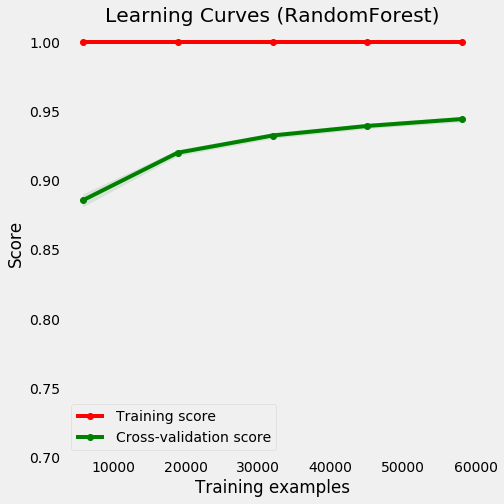

In [48]:
title = "Learning Curves (RandomForest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)  # changed 100 to 50
estimator = RandomForestClassifier(**mdl_params)
ylim = (0.7, 1.01)
n_jobs = 7
train_sizes = np.linspace(.1, 1.0, 5)
fig = plt.figure(figsize=(7, 7))
plt.title(title)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
    estimator, all_X, all_y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
plt.show()
# plt.savefig('loanwords.prob.solutions.learningcurve.png')


# Appendix

### Find which texts have the most Greek

In [52]:
corpus_files = {}
latin_reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')
greek_in_corpus_selection = set()
found_greek = []

for full_path in tqdm(latin_reader.fileids(), total=len(reader.fileids()), unit='files'):
    filename = full_path[full_path.rfind('/') + 1:]
    unseen_X = process_latin_text_pipeline.fit_transform(list(latin_reader.sents([full_path])))
    distinct_unseen = distinct_words(unseen_X)
    unseen_words = list(distinct_unseen)
    total_words = [word
                   for sentence in unseen_X
                   for word in sentence]
    arr = classifier.predict(np.array([word_to_features(word, max_len) for word in total_words]))
    total_greek_words = np.count_nonzero(arr)
    marks = arr.tolist()
    if marks:
        found_greek = [total_words[idx]
                       for idx, point in enumerate(marks)
                       if point == 1]
        greek_in_corpus_selection |= set(found_greek)
        corpus_files[filename] = (len(total_words), total_greek_words)


100%|██████████| 2141/2141 [1:11:10<00:00,  2.49s/files]


In [55]:
print(f'Total Greek words found in Latin selection {len(greek_in_corpus_selection):,}')
print(f'Number of Greek words not in training data: {len(greek_in_corpus_selection - only_greek_transliterated):,}')
print(f'Random sample: {random.sample(greek_in_corpus_selection, 20)}')

Total Greek words found in Latin selection 85,440
Number of Greek words not in training data: 83,125
Random sample: ['compactiles', 'Morpheo', 'Eggideo', 'permoreris', 'emptitios', 'Gratianense', 'dichomenis', 'chutheni', 'ceraste', 'munde', 'supponas', 'aethereis', 'montanea', 'Opisphora', 'praefamino', 'Ariarathi', 'binas', 'bacchilatria', 'communituri', 'Ir']


In [56]:
print(len(corpus_files ))
rankings = [ (key, val[0], val[1], val[1]/val[0]) for key, val in corpus_files.items()]
rankings.sort(key=lambda x: x[3])
for rank in rankings:
    print (rank)

2039
('gall5.txt', 7489, 0, 0.0)
('dumestas.txt', 13, 0, 0.0)
('eutropius1.txt', 1569, 0, 0.0)
('eutropius9.txt', 2083, 0, 0.0)
('janus2.txt', 2, 0, 0.0)
('liv.per.txt', 2, 0, 0.0)
('liv.per106.txt', 111, 0, 0.0)
('liv.per108.txt', 81, 0, 0.0)
('liv.per114.txt', 92, 0, 0.0)
('liv.per115.txt', 77, 0, 0.0)
('liv.per12.txt', 93, 0, 0.0)
('liv.per120.txt', 135, 0, 0.0)
('liv.per121.txt', 42, 0, 0.0)
('liv.per122.txt', 35, 0, 0.0)
('liv.per123.txt', 66, 0, 0.0)
('liv.per125.txt', 69, 0, 0.0)
('liv.per127.txt', 105, 0, 0.0)
('liv.per129.txt', 80, 0, 0.0)
('liv.per13.txt', 166, 0, 0.0)
('liv.per130.txt', 74, 0, 0.0)
('liv.per133.txt', 78, 0, 0.0)
('liv.per136-7.txt', 4, 0, 0.0)
('liv.per138.txt', 18, 0, 0.0)
('liv.per140.txt', 34, 0, 0.0)
('liv.per15.txt', 65, 0, 0.0)
('liv.per65.txt', 72, 0, 0.0)
('liv.per66.txt', 41, 0, 0.0)
('liv.per82.txt', 76, 0, 0.0)
('liv.per83.txt', 139, 0, 0.0)
('liv.per84.txt', 115, 0, 0.0)
('liv.per87.txt', 34, 0, 0.0)
('liv.per88.txt', 125, 0, 0.0)
('liv.per90.txt

('theod16.txt', 19590, 1572, 0.08024502297090352)
('mart4.txt', 3950, 318, 0.08050632911392405)
('ezra.txt', 5158, 416, 0.08065141527723924)
('theod06.txt', 17630, 1422, 0.08065796937039138)
('ter.phormio.txt', 9505, 767, 0.08069437138348237)
('janus1.txt', 2400, 194, 0.08083333333333333)
('theod10.txt', 11599, 938, 0.08086904043452021)
('varro.frag.txt', 1632, 132, 0.08088235294117647)
('sabinus1.txt', 863, 70, 0.08111239860950174)
('theod15.txt', 8260, 670, 0.0811138014527845)
('vidularia.txt', 763, 62, 0.08125819134993446)
('fulbert.txt', 98, 8, 0.08163265306122448)
('albertanus.sermo2.txt', 3183, 260, 0.08168394596292805)
('theod13.txt', 9741, 798, 0.08192177394518016)
('piccolomini.carmen.txt', 366, 30, 0.08196721311475409)
('jude.txt', 425, 35, 0.08235294117647059)
('mir1.txt', 771, 64, 0.08300907911802853)
('hugo4.txt', 4165, 347, 0.08331332533013205)
('nemesianus2.txt', 611, 51, 0.08346972176759411)
('curculio.txt', 6336, 531, 0.08380681818181818)
('campion.thamesin.txt', 1905,

# That's all for now folks!